# Enhance ShopAssist AI (ShopAssist 2.0)

> Project by Neeraj Kumar Bhola




## Part 1: Introduction




#### Project Background

In today's digital age, online shopping has become the go-to option for many consumers. However, the overwhelming number of choices and the lack of personalized assistance can make the shopping experience daunting. To address this, we have developed **ShopAssist AI, a chatbot that combines the power of large language models and rule-based functions to ensure accurate and reliable information delivery**.


#### Problem Statement

*Given a dataset containing information about laptops (product names, specifications, descriptions, etc.), build a chatbot that parses the dataset and provides accurate laptop recommendations based on user requirements*.


You can load the data and see it here.

In [5]:
# Install OpenAI library
!pip install -q openai tenacity


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Import other libraries
import pandas as pd
from IPython.display import display, HTML
pd.set_option('display.width',100)

In [8]:
filepath = '/content/drive/MyDrive/GenAI_Project/'

#### Approach:

1. **Conversation and Data Collection**: The chatbot engages in natural dialogue using LLMs to understand user preferences and requirements.
2. **Information Extraction**: Once key information is gathered, rule-based functions identify the top three laptops that best match the user's needs.
3. **Personalized Recommendations**: The chatbot continues the conversation to answer follow-up questions and assist users in selecting the ideal laptop.

## Part 2: System Design


#### Dataset

We have a dataset `laptop_data.csv` where  each row describes the features of a single laptop and also has a small description at the end. The chatbot that we build will leverage LLMs to parse this `Description` column and provide recommendations

#### Workings of the Chatbot



The chatbot should ask a series of questions to determine the user's requirments. To make it simple, we have used 6 features to encapsulate the user's needs.
  
  To identify user needs, the chatbot focuses on six key features:
    - GPU intensity
    - Display quality
    - Portability
    - Multitasking
    - Processing speed
    - Budget

- Confirm if the user's requirements have been correctly captured at the end.

After confirming the user’s preferences, the chatbot lists the top 3 matching laptops and continues to assist with further queries.




# ShopAssist 1.0

#### Building the Chatbot

Below is the system design for the chatbot for **ShopAssist 1.0**.

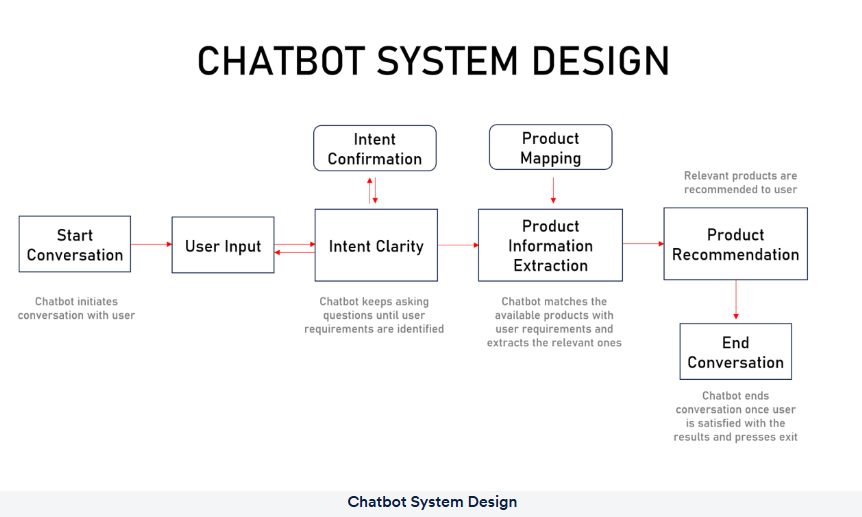

**Stage 1**

- Intent Clarity Layer
- Intent Confirmation Layer

**Stage 2**

- Product Mapping Layer
- Product Information Extraction Layer

**Stage 3**

- Product Recommendation Layer

##### Major functions behind the Chatbot ShopAssist

Let us now look at a brief overview of the major functions that form the chatbot and then deep live later:

- `initialize_conversation()`: This initializes the variable conversation with the system message.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant
- `moderation_check()`: This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, it ends the conversation.
- `intent_confirmation_layer()`: This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not GPU intensity, Display quality, Portability, Multitasking, Processing speed, Budget
- `dictionary_present()`: This function checks if the final understanding of user's profile is returned by the chatbot as a python dictionary or not. If there is a dictionary, it extracts the information as a Python dictionary.
- `compare_laptops_with_user()`: This function compares the user's profile with the different laptops and come back with the top 3 recommendations.
- `initialize_conv_reco()`: Initializes the recommendations conversation

In the next sections, we will see how to write the code for the above functions

# ShopAssist 2.0

But in development of **ShopAssist2.0** , we leverage from Function Calling feature for improved performance and simple architecture.

The architecture looks as shown below:

**Stage 1**

- Intent Clarity Layer

**Stage 2**

- Product Mapping Layer

**Stage 3**

- Product Recommendation Layer

The following layers from ShopAssist 1.0 **are removed** as their purpose are filled by now using **Function Calling** in OpenAI API.

1. intent_confirmation_layer()
2. dictionary_present()
3. initialize_conv_reco()

## Part 3: Implementation

## Part-2 System Design and Implementation - Stage 1

### 1.1 - Import the libraries

Importing libraries that are require for this project:
- openai
- os, json, ast
- pandas

Make sure the api key is stored in the text file `OPENAI_API_Key.txt` in your google drive linked above.

In [9]:
# Import the libraries
import os, json, ast
import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt

In [10]:
# Read the OpenAI API key from Gdrive
with open(filepath + "OpenAI_API_Key.txt","r") as f:
  openai.api_key = ' '.join(f.readlines())

### 1.2 - Implementing Intent Clarity Layer


- `initialize_conversation()`


### `initialize_conversation()`:
This initializes the variable conversation with the system message. Using prompt engineering and chain of thought reasoning, the function will enable the chatbot to keep asking questions until the user requirements have been captured in a dictionary. It also includes Few Shot Prompting (sample conversation between the user and assistant) to align the model about user and assistant responses at each step.

In [11]:
# initialize_conversation function
def initialize_conversation():
  '''
  Returns a list [{'role':'system','content': system_message}]
  '''
  delimiter = '####'


  system_message = f'''
  You are very intelligent laptop gadget expert and your goal is to find out best laptop for a user for given input.
  You need to ask relevant questions to the user and understand the user profile  by analysing the user's responses.
  Your final objective is to get following parameters from user's conversation. The parameters are 'GPU intensity','Display quality','Portability','Multitasking','Processing speed'and'Budget', and be confident of the values.
  You need to ask probing questions to the user in case any of these parameters are not obtained from user's interaction.
  The value for the 'Budget' should be numerical value extracted from user's response.
  The value of all keys except 'Budget' should be either 'high' or 'medium' or 'low' based on the importance of the corresponding keys as stated by user.
  All the values in the example dictionary are only representative values.
  {delimiter}
  Here are some instructions around the values for the different keys. if you do not follow this, you will be heavily penalized.
  - The value of all keys except 'Budget' should be strictly either 'high' or 'medium' or 'low' based on the importance of the corresponding keys as stated by user.
  - The value for the 'Budget' should be numerical value extracted from user's response.
  - 'Budget' value needs to be greater than or equal to 24999 INR. If the user says less than that, please mention to user that there are no laptops in that range.
  - Please do not randomly assign any value to the parameters.
  - The value needs to be inferred from the user's response.
  - Please ask one question at a time to capture values for the parameters.
  {delimiter}

  Once you have obtained all the parameter, your goal is to extract details of the top 3 laptops matching to the parameters obtaned earlier in the user's conversation .
  And this you will do by function calling with compare_laptops_with_user function.

  {delimiter}
    Once you get the list of top 3 laptops you will need to present the details in the personlized format it and show the recomendations to the
    user in the following format:
    1. <Laptop name>: <Basic laptop specs in brief>, <price of laptop>
    2. <Laptop name>: <Basic laptop specs in brief>, <price of laptop>
    3. <Laptop name>: <Basic laptop specs in brief>, <price of laptop>
  {delimiter}

  Follow below steps when interacting with user.

  Step 1 : Start with a short welcome message and encourage the user to share their requirement precisely on the laptop needed.
  Remember, you only recommend on laptop, if user is asking anything else then you apologizes and remind user that you are laptop expert only. Please do not ask more than one questions at a time.

  Step 2 : Based on the user input obtained from conversation, you try to get values for 'GPU intensity','Display quality','Portability','Multitasking','Processing speed'and'Budget'.

  Step 3 : In case, details are not clear , ask clarifying question to user to get the details for above parameters.

  Step 4 : When all the parameters are available you invoke function calling with compare_laptops_with_user function.

  Step 5 : Personalize the recommendation obtained from compare_laptops_with_user function and present to the user.

  Step 6 : If user changes any of the request then repeat step 2 to 5.


  {delimiter}
  Here are some notes which you should take care of. If you do not folow this you will be heavily penalized.
  - The values for all keys, except 'Budget', should strictly be either 'low', 'medium', or 'high' based on the importance of the corresponding keys, as stated by user.
  - The value for 'budget' should be a numerical value extracted from the user's response. It needs to be greater than or equal to 24999 INR.
  - Do not ask questions to user for more 1 parameter at a time.
  - Do not ask too many questions in one shot.
  - Do not reply on any other subject other than laptop and its parameters.


    {delimiter}
  Her is a sample conversation between user and AI assistant:
  User Input : 'Hi, I am an editor.'
  Assistant : 'Great! As an editor, you likely require a laptop tha can handle demanding tasks. hence , the laptop should have high multitasking capability. You would also need a high end display for better visuals and editing. May I know what kind of work do you primarily focus on ? Are you more involved in video editing , photo editing or both ? Understanding the specific type of editing work will help me to tailor my recommendation accordingly. Let me know if my understanding is correct until now.  '
  User Input : ' I primarily work with after effects. '
  Assistant : ' Thank you for providing that information. Working with after effects involves working with graphics, animations and rendering which will require high GPU. Do you work with high resolution media files, such as 4K videos or RAW photos ? Understanding your file sizes will help determine the stoprage capacity and processing power needed. '
  User Input : ' Yes, sometimes I work with 4K videos as well. '
  Assistant : ' Thank you for the information. Processing 4K videos will require a good and high GPU. I think we have already determined earlier that you need a high CPU. To ensure that I have a complete understanding of your needs, I have one more question : Are you frequently on the go and require a laptop that s light weight and easy to carry, or do you primarily work from a stationary location ?  '
  User Input : ' Yes, sometimes I travel but do not carry my laptop. '
  Assistant : ' Could you kindly let me know your budget for the laptop ? This will help me to find the options that fit within your price range while meeting the specified requirements. '
  User Input : ' My maximum budget is 1.5 lakh INR. '

  {delimiter}

  {delimiter}
  Here is another sample conversation between the user and assistant:
  User Input: "I am a coder and i need higher end laptop with high multitasking feature"
  Assistant: "Great! As a coder, you likely require a laptop that can handle demanding tasks. Hence, the laptop should have high multitasking capability. Could you please specify the importance of GPU intensity, display quality, portability, processing speed, and budget in order to tailor my recommendation accordingly?"
  User Input: "Yes, you are right"
  Assistant: "Great! Do you prefer a laptop that is easy to carry around or do you primarily use it at a fixed location?"
  User Input: "I only need it for home use."
  Assistant: "Thank you for specifying that. Do you often have multiple tasks running on your laptop simultaneously or primarily focus on one task at a time?"
  User Input: "I ususally have multiple tasks running"
  Assistant: "Thank you for sharing that. Do you prefer a laptop with fast processing speed for quick performance?"
  User Input: "yes i need it to be very quick"
  Assistant: "Appreciate that input. Finally, what is your budget range for the laptop you are looking to purchase?"
  User Input: "i would like if it is not more than 125000 INR"


  {delimiter}
  Here is another sample conversation between the user and assistant:
  User Input: "I am a basic business user"
  Assistant: "As a basic business user, it's important to have a reliable laptop for your day-to-day tasks. Based on your usage as a basic business user, do you prefer a laptop with a good quality display for presentations?"
  User Input: "Yes, you right"
  Assistant: "Great! Do you prefer a laptop that is easy to carry around or do you primarily use it at a fixed location?"
  User Input "I need it to be easy to carry around as I travel frequently on business trips"
  Assistant: "Thank you for specifying that. Do you often have multiple tasks running on your laptop simultaneously or primarily focus on one task at a time?"
  User Input: "i ususally have multiple tasks running"
  Assistant: "Thank you for sharing that. Do you prefer a laptop with fast processing speed for quick performance?"
  User Input: "yes i need it to be very quick"
  Assistant: "Appreciate that input. Finally, what is your budget range for the laptop you are looking to purchase?"
  User Input: "i would like if it is not more than 1 lakh"


  '''

  conversation = [{'role' : 'system' , 'content' : system_message}]

  return conversation

Let's now look at the next function.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant. We'll use the Chat Completions function for performing LLM calls to OpenAI.

### `get_chat_completions()`:

This function perform LLM call using the Chat Completions API to get the LLM response.

In [12]:
# Define a Chat Completions API call
# Retry up to 6 times with exponential backoff, starting at 1 second and maxing out at 20 seconds delay
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_chat_completions(input, json_format = False):

    MODEL = 'gpt-4o-mini'

    system_message_json_output = """<<. Return output in JSON format to the key output.>>"""


    try:
      # If the output is required to be in JSON format
      if json_format == True:
          # Append the input prompt to include JSON response as specified by OpenAI
          messages = input + [{"role": "system", "content": system_message_json_output}]

          # JSON return type specified
          chat_completion_json = openai.chat.completions.create(
              model = MODEL,
              messages = messages,
              response_format = { "type": "json_object"},
              seed = 1234)

          output = json.loads(chat_completion_json.choices[0].message.content)

      # No JSON return type specified
      else:
          message = input
          chat_completion = openai.chat.completions.create(
              model = MODEL,
              messages = input,
              seed = 2345)

          output = chat_completion.choices[0].message.content
      return output

    # Handling exception
    except Exception as e:
      print(f"An error occurred while calling OpenAI API :  {e}")
      return "None"

### `moderation_check()`:
 This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, you can add a break statement to end the conversation.

In [13]:
# Define a function called moderation_check that takes user_input as a parameter.

def moderation_check(user_input):
    # Call the OpenAI API to perform moderation on the user's input.
    response = openai.moderations.create(input=user_input)

    # Extract the moderation result from the API response.
    moderation_output = response.results[0].flagged
    # Check if the input was flagged by the moderation system.
    if response.results[0].flagged == True:
        # If flagged, return "Flagged"
        return "Flagged"
    else:
        # If not flagged, return "Not Flagged"
        return "Not Flagged"

## Stage 2

### 2.1 Implementing the Product Mapping


### `product_map_layer()`:

This function is responsible for extracting key features and criteria from laptop descriptions. Here's a breakdown of how it works:

-  Use a prompt that assign it the role of a Laptop Specifications Classifier, whose objective is to extract key features and classify them based on laptop descriptions.

- Provide step-by-step instructions for extracting laptop features from description.

- Assign specific rules for each feature (e.g., GPU Intensity, Display Quality, Portability, Multitasking, Processing Speed) and associate them with the appropriate classification value (Low, Medium, or High).

- Includes Few Shot Prompting (sample conversation between the user and assistant) to demonstrate the expected result of the feature extraction and classification process.

In [14]:
def product_map_layer(laptop_description):
    delimiter = "#####"

    lap_spec = {
        "GPU intensity":"(Type of the Graphics Processor)",
        "Display quality":"(Display Type, Screen Resolution, Display Size)",
        "Portability":"(Laptop Weight)",
        "Multitasking":"(RAM Size)",
        "Processing speed":"(CPU Type, Core, Clock Speed)"
    }

    values = {'low','medium','high'}

    prompt=f"""
    You are a Laptop Specifications Classifier whose job is to extract the key features of laptops and classify them as per their requirements.
    To analyze each laptop, perform the following steps:
    Step 1: Extract the laptop's primary features from the description {laptop_description}
    Step 2: Store the extracted features in {lap_spec} \
    Step 3: Classify each of the items in {lap_spec} into {values} based on the following rules: \
    {delimiter}
    GPU Intensity:
    - low: <<< if GPU is entry-level such as an integrated graphics processor or entry-level dedicated graphics like Intel UHD >>> , \n
    - medium: <<< if mid-range dedicated graphics like M1, AMD Radeon, Intel Iris >>> , \n
    - high: <<< high-end dedicated graphics like Nvidia RTX >>> , \n

    Display Quality:
    - low: <<< if resolution is below Full HD (e.g., 1366x768). >>> , \n
    - medium: <<< if Full HD resolution (1920x1080) or higher. >>> , \n
    - high: <<< if High-resolution display (e.g., 4K, Retina) with excellent color accuracy and features like HDR support. >>> \n

    Portability:
    - high: <<< if laptop weight is less than 1.51 kg >>> , \n
    - medium: <<< if laptop weight is between 1.51 kg and 2.51 kg >>> , \n
    - low: <<< if laptop weight is greater than 2.51 kg >>> \n

    Multitasking:
    - low: <<< If RAM size is 8 GB, 12 GB >>> , \n
    - medium: <<< if RAM size is 16 GB >>> , \n
    - high: <<< if RAM size is 32 GB, 64 GB >>> \n

    Processing Speed:
    - low: <<< if entry-level processors like Intel Core i3, AMD Ryzen 3 >>> , \n
    - medium: <<< if Mid-range processors like Intel Core i5, AMD Ryzen 5 >>> , \n
    - high: <<< if High-performance processors like Intel Core i7, AMD Ryzen 7 or higher >>> \n
    {delimiter}

    {delimiter}
    Here is input output pair for few-shot learning:
    input 1: "The Dell Inspiron is a versatile laptop that combines powerful performance and affordability. It features an Intel Core i5 processor clocked at 2.4 GHz, ensuring smooth multitasking and efficient computing. With 8GB of RAM and an SSD, it offers quick data access and ample storage capacity. The laptop sports a vibrant 15.6" LCD display with a resolution of 1920x1080, delivering crisp visuals and immersive viewing experience. Weighing just 2.5 kg, it is highly portable, making it ideal for on-the-go usage. Additionally, it boasts an Intel UHD GPU for decent graphical performance and a backlit keyboard for enhanced typing convenience. With a one-year warranty and a battery life of up to 6 hours, the Dell Inspiron is a reliable companion for work or entertainment. All these features are packed at an affordable price of 35,000, making it an excellent choice for budget-conscious users."
    output 1: {{'GPU intensity': 'medium','Display quality':'medium','Portability':'medium','Multitasking':'high','Processing speed':'medium'}}

    {delimiter}
    ### Strictly don't keep any other text in the values of the JSON dictionary other than low or medium or high ###
    """
    input = f"""Follow the above instructions step-by-step and output the dictionary in JSON format {lap_spec} for the following laptop {laptop_description}."""
    #see that we are using the Completion endpoint and not the Chatcompletion endpoint
    messages=[{"role": "system", "content":prompt },{"role": "user","content":input}]

    response = get_chat_completions(messages, json_format = True)

    return response

Let's now apply this function to the entire laptop dataset

In [15]:
##Run this code once to extract product info in the form of a dictionary
laptop_df= pd.read_csv(filepath + 'laptop_data.csv')

In [17]:
laptop_df.columns

Index(['Brand', 'Model Name', 'Core', 'CPU Manufacturer', 'Clock Speed', 'RAM Size',
       'Storage Type', 'Display Type', 'Display Size', 'Graphics Processor', 'Screen Resolution',
       'OS', 'Laptop Weight', 'Special Features', 'Warranty', 'Average Battery Life', 'Price',
       'Description'],
      dtype='object')

In [25]:
# Understanding the text of Description column
print(laptop_df.Description)

0     The Dell Inspiron is a versatile laptop that c...
1     The MSI GL65 is a high-performance laptop desi...
2     The HP EliteBook is a premium laptop designed ...
3     The Lenovo IdeaPad is a versatile laptop that ...
4     The ASUS ZenBook Pro is a high-end laptop that...
5     The Acer Predator is a powerhouse laptop desig...
6     The Microsoft Surface Laptop is a premium devi...
7     The Lenovo ThinkPad is a powerful laptop desig...
8     The HP Pavilion is a budget-friendly laptop th...
9     The ASUS ROG Strix G is a high-performance gam...
10    The Dell XPS 15 is a premium laptop that combi...
11    The Lenovo ThinkPad X1 Carbon is a sleek and l...
12    The Acer Swift 3 is a lightweight and affordab...
13    The Apple MacBook Air is a sleek and lightweig...
14    The MSI Prestige 14 is a compact and stylish l...
15    The ASUS ZenBook 13 is a lightweight and power...
16    The Dell Precision 5550 is a high-performance ...
17    The HP ENVY x360 is a versatile 2-in-1 con

In [26]:
## Create a new column "laptop_feature" that contains the dictionary of the product features
laptop_df['laptop_feature'] = laptop_df['Description'].apply(lambda x: product_map_layer(x))

In [30]:
# checking for the laptop_feature column
laptop_df.columns

Index(['Brand', 'Model Name', 'Core', 'CPU Manufacturer', 'Clock Speed', 'RAM Size',
       'Storage Type', 'Display Type', 'Display Size', 'Graphics Processor', 'Screen Resolution',
       'OS', 'Laptop Weight', 'Special Features', 'Warranty', 'Average Battery Life', 'Price',
       'Description', 'laptop_feature'],
      dtype='object')

In [31]:
# checking the data in laptop_feature column
print(laptop_df.laptop_feature)

0     {'output': {'GPU intensity': 'low', 'Display q...
1     {'output': {'GPU intensity': 'high', 'Display ...
2     {'output': {'GPU intensity': 'low', 'Display q...
3     {'output': {'GPU intensity': 'low', 'Display q...
4     {'output': {'GPU intensity': 'high', 'Display ...
5     {'GPU intensity': 'high', 'Display quality': '...
6     {'output': {'GPU intensity': 'medium', 'Displa...
7     {'output': {'GPU intensity': 'high', 'Display ...
8     {'output': {'GPU intensity': 'low', 'Display q...
9     {'output': {'GPU intensity': 'high', 'Display ...
10    {'output': {'GPU intensity': 'high', 'Display ...
11    {'output': {'GPU intensity': 'low', 'Display q...
12    {'output': {'GPU intensity': 'medium', 'Displa...
13    {'output': {'GPU intensity': 'medium', 'Displa...
14    {'output': {'GPU intensity': 'high', 'Display ...
15    {'output': {'GPU intensity': 'medium', 'Displa...
16    {'output': {'GPU intensity': 'high', 'Display ...
17    {'output': {'GPU intensity': 'medium', 'Di

In [32]:
laptop_df.head(5)

Brand   Model Name Core CPU Manufacturer Clock Speed RAM Size Storage Type Display Type  \
0    Dell     Inspiron   i5            Intel     2.4 GHz      8GB          SSD          LCD   
1     MSI         GL65   i7            Intel     2.6 GHz     16GB      HDD+SSD          IPS   
2      HP    EliteBook   i7            Intel     2.8 GHz     16GB          SSD          LED   
3  Lenovo      IdeaPad   i3            Intel     2.1 GHz      8GB          HDD           TN   
4    ASUS  ZenBook Pro   i9            Intel     3.1 GHz     64GB          SSD         OLED   

  Display Size Graphics Processor Screen Resolution          OS Laptop Weight    Special Features  \
0        15.6"          Intel UHD         1920x1080  Windows 10        2.5 kg    Backlit Keyboard   
1        15.6"         NVIDIA GTX         1920x1080  Windows 10        2.3 kg        RGB Keyboard   
2          14"          Intel UHD         1920x1080  Windows 11        1.5 kg  Fingerprint Sensor   
3        15.6"          Intel UHD          1366x768  Windows 10        2.2 kg         Dolby Audio   
4        15.6"         NVIDIA RTX         3840x2160  Windows 10        1.8 kg    NanoEdge Display   

  Warranty Average Battery Life    Price                                        Description  \
0   1 year              6 hours   35,000  The Dell Inspiron is a versatile laptop that c...   
1  2 years              4 hours   55,000  The MSI GL65 is a high-performance laptop desi...   
2  3 years              8 hours   90,000  The HP EliteBook is a premium laptop designed ...   
3   1 year              5 hours   25,000  The Lenovo IdeaPad is a versatile laptop that ...   
4  2 years              7 hours  200,000  The ASUS ZenBook Pro is a high-end laptop that...   

                                      laptop_feature  
0  {'output': {'GPU intensity': 'low', 'Display q...  
1  {'output': {'GPU intensity': 'high', 'Display ...  
2  {'output': {'GPU intensity': 'low', 'Display q...  
3  {'output': {'GPU intensity': 'low', 'Display q...  
4  {'output': {'GPU intensity': 'high', 'Display ...

In [33]:
## Save this updated csv file so that it can used next time and we do not need to perform this again until we have new details.
laptop_df.to_csv(filepath + "laptop_dataset_with_features.csv",index=False,header = True)

### `compare_laptops_with_user()`:

This function evaluates the user's profile against available laptops and returns the top recommendations. It follows these steps:
    - Accepts a dictionary of user requirements as input.

    - Filters the laptops to include only those within the user's budget.

    - Assigns a score to each laptop based on how closely it aligns with the user's preferences.

    - Sorts the laptops in descending order of their scores.
    
    - Returns the top three laptops in a JSON-formatted string.
    
    

In [34]:
def compare_laptops_with_user(user_req_string):

  # reading updated input data for laptop details which has features details
  df = pd.read_csv(filepath + 'laptop_dataset_with_features.csv')
  user_requirements = user_req_string

  # extract budget value from user requirement and convert into integer
  budget = user_requirements.get('Budget',0)

  # create a copy of dataframe after filtering on the budget
  df_filtered = df.copy()
  df_filtered['Price'] =  df_filtered['Price'].str.replace(',','').astype(int)
  df_filtered = df_filtered[df_filtered['Price'] <= budget]

  # Mapping string value low medium and high to 0,1 and 2 respectively
  mappings = {'low' : 0 , 'medium' : 1 , 'high' : 2}

  # creating a new column score and initializing it to 0
  df_filtered['Score'] = 0

  # now for each laptop, calculate the score based on the input requirement
  for index,row in df_filtered.iterrows():
    laptop_values = ast.literal_eval(row['laptop_feature'])
    score = 0

    # now comparing the keys in the laptop values and user requirement
    for key,user_value in user_requirements.items():
      if key == 'Budget':
        continue # skip the comparision
      laptop_value = laptop_values.get(key,None)

      # checking in mapping
      laptop_mapping = mappings.get(laptop_value,-1)
      user_mapping   = mappings.get(user_value,-1)

      if laptop_mapping >= user_mapping:
        score += 1

    df_filtered.loc[index,'Score'] = score # updating the score to dataframe

  # sorting laptops by score in descending order and selecting 3 products
  top_laptops = df_filtered.drop('laptop_feature', axis = 1)
  top_laptops = top_laptops.sort_values('Score',ascending=False).head(3)

  # converting the top_laptops dataframe to json format
  top_laptops_json = top_laptops.to_json(orient='records')

  return top_laptops_json



## Stage 3

### 3.1: Product Recommendation Layer

The final stage is the product recommendation layer. It utilizes the output from the 'compare_laptops_with_user' function and delivers the results to the user. This layer performs the following actions:
1. Continues the dialogue to guide the recommendation process.
2. Formats and presents the recommended laptops in a user-friendly manner.
3. Engages the user with follow-up questions based on the provided recommendations.



In [35]:
def get_chat_completions_function_calling(input):

    model = 'gpt-4o-mini'

    # defining the function call parameters
    tools = [
        {
            "type": "function",
            "function": {
                "name": "compare_laptops_with_user",
                "description": "Get the top 3 laptops for the user from the catalogue available based on parameters like GPU intensity, Display quality, Portability, Multitasking, Processing speed, and Budget",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "GPU intensity": {
                            "type": "string",
                            "description": "The GPU intensity requirement of the user specified as low, medium or high"
                        },
                        "Display quality": {
                            "type": "string",
                            "description": "The Display Quality requirement of the user specified as low, medium or high"
                        },
                        "Portability": {
                            "type": "string",
                            "description": "The Portability requirement of the user specified as low, medium or high"
                        },
                        "Multitasking": {
                            "type": "string",
                            "description": "The Multitasking requirement of the user specified as low, medium or high"
                        },
                        "Processing speed": {
                            "type": "string",
                            "description": "The Processing speed requirement of the user specified as low, medium or high"
                        },
                        "Budget": {
                            "type": "integer",
                            "description": "The maximum budget of the user"
                        },
                    },
                    "required": [
                        "GPU intensity",
                        "Display quality",
                        "Portability",
                        "Multitasking",
                        "Processing speed",
                        "Budget"
                    ]
                }
            }
        }
    ]


    try:
        messages = input

        response = openai.chat.completions.create(
            model = model,
            messages = messages,
            temperature = 0,
            tools = tools,
            tool_choice = 'auto',
            seed = 4567
        )

        # check if the model wanted to call a function
        tool_calls = response.choices[0].message.tool_calls

        # call the function
        if tool_calls:
            available_functions = {
                "compare_laptops_with_user": compare_laptops_with_user,
            }

            # append response given by gpt to input messages list
            messages.append(response.choices[0].message)

            for tool_call in tool_calls:
                function_name = tool_call.function.name
                function_to_call = available_functions[function_name]
                function_args = json.loads(tool_call.function.arguments)
                function_response = function_to_call(function_args)

                function_call_response_dict = {
                    "tool_call_id": tool_call.id,
                    "role": "tool",
                    "name": function_name,
                    "content": function_response,
                }

                # append response_messages to the original input messages
                messages.append(function_call_response_dict)

                # make a second call to the LLM to personalize the function output
                second_response = openai.chat.completions.create(
                    model = model,
                    messages = messages,
                    temperature = 0 ,
                    seed = 5678

                )

                second_response_message = [{"role": "assistant", "content": second_response.choices[0].message.content}]
                return second_response_message
        else:
            response_message = [{"role": "assistant", "content": response.choices[0].message.content}]
            return response_message

    # Raise exception error
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

## Stage 4 - Combining all the 3 stages

Now, we will combine all three stages that we defined above.

**Stage 1** + **Stage 2** + **Stage 3**

### 4.1 Dialogue Management System

Bringing everything together, we create a `diagloue_mgmt_system()` function that contains the logic of how the different layers would interact with each other. This will be the function that we'll call to initiate the chatbot

In [37]:
def dialogue_mgmt_system():
    # initialize the conversation
    conversation = initialize_conversation()
    # First message from Assistant
    print("Assistant:\nHow may I help you with your laptop selection? To exit the conversation type 'EXIT'.\n")

    user_input = ''

    # Loop till user exits
    while user_input.lower() != 'exit':
        print("User Input: ")
        user_input = input()
        # Moderation Check for user input
        moderation = moderation_check(user_input)
        if moderation == 'Flagged':
            print("\nAssistant:\nSorry, this message has been flagged. Please restart your conversation.\n")
            break

        if user_input.lower() == 'exit':
            print("\nAssistant:\nThank you for using this service. Please do not hesitate to contact us if you need assistance. See you soon!\n")
            break

        conversation.append({"role": "user", "content": user_input})
        response = get_chat_completions_function_calling(conversation)

        # Moderation Check for LLM response
        moderation = moderation_check(response[0]['content'])
        if moderation == 'Flagged':
            print("\nAssistant:\nSorry, this message has been flagged. Please restart your conversation.\n")
            break

        print("\nAssistant:\n", response[0]['content'], '\n')

        conversation += response

In [38]:
#Chatbot API - Dialogue Management System-1
dialogue_mgmt_system()

Assistant:
How may I help you with your laptop selection? To exit the conversation type 'EXIT'.

User Input: 
i am looking for a laptop

Assistant:
 Welcome! I'd be happy to help you find the perfect laptop. Could you please share your specific requirements or what you'll primarily be using the laptop for? 

User Input: 
I am looking for a laptop to help me with gamining

Assistant:
 Great! For gaming, it's important to have a laptop with a strong GPU, good display quality, and fast processing speed. 

To better understand your needs, could you please tell me how important GPU intensity is for you? Would you say it's high, medium, or low? 

User Input: 
medium

Assistant:
 Thank you for that information! Now, how important is display quality for your gaming experience? Would you rate it as high, medium, or low? 

User Input: 
high

Assistant:
 Got it! Display quality is high for your gaming needs. 

Next, how important is portability for you? Would you consider it high, medium, or low?

In [39]:
#Chatbot API - Dialogue Management System-2
dialogue_mgmt_system()

Assistant:
How may I help you with your laptop selection? To exit the conversation type 'EXIT'.

User Input: 
help me with a trip to goa for 4 days

Assistant:
 I'm sorry, but I'm a laptop expert and can only assist you with laptop-related queries. If you have any questions about laptops or need help finding the right one for your needs, feel free to ask! 

User Input: 
exit

Assistant:
Thank you for using this service. Please do not hesitate to contact us if you need assistance. See you soon!



In [40]:
#Chatbot API - Dialogue Management System-3
dialogue_mgmt_system()


Assistant:
How may I help you with your laptop selection? To exit the conversation type 'EXIT'.

User Input: 
laptop

Assistant:
 Hello! I'm a laptop expert and I'm here to help you find the perfect laptop for your needs. Could you please share your requirements or what you plan to use the laptop for? 

User Input: 
for coding

Assistant:
 Great! As a coder, you'll likely need a laptop that can handle demanding tasks. Could you please specify the importance of GPU intensity, display quality, portability, processing speed, and budget in order to tailor my recommendation accordingly? 

User Input: 
High GPU, Good Display, Medium Portability, High Processing Speed, Budget < 60000

Assistant:
 Thank you for sharing that information. However, I need to inform you that the budget you mentioned is below the minimum requirement of 24,999 INR for laptops. Could you please provide a budget that meets or exceeds this amount? 

User Input: 
24999

Assistant:
 It seems that there are no laptops ava

In [41]:
#Chatbot API - Dialogue Management System-4
dialogue_mgmt_system()

Assistant:
How may I help you with your laptop selection? To exit the conversation type 'EXIT'.

User Input: 
help me convert 1040 USD to INR

Assistant:
 I'm sorry, but I can only assist you with laptop-related queries. If you have any questions about laptops or need help finding one, feel free to ask! 

User Input: 


Assistant:
 It seems like you didn't provide any input. If you have any questions or need assistance with finding a laptop, please let me know! I'm here to help. 

User Input: 
exit

Assistant:
Thank you for using this service. Please do not hesitate to contact us if you need assistance. See you soon!



In [43]:
#Chatbot API - Dialogue Management System-5
dialogue_mgmt_system()

Assistant:
How may I help you with your laptop selection? To exit the conversation type 'EXIT'.

User Input: 
how to exit

Assistant:
 I'm here to assist you with laptop recommendations. If you have any questions or need help finding a laptop, feel free to ask! 

User Input: 
how will you help me

Assistant:
 I can help you find the best laptop based on your specific needs and preferences. To do that, I'll ask you a few questions about what you're looking for in a laptop, such as its performance, display quality, portability, multitasking capabilities, and your budget. Once I have that information, I can recommend some suitable options for you. Would you like to get started? 

User Input: 
how will you search laptop for me

Assistant:
 I will ask you a series of questions to understand your requirements for a laptop, including factors like GPU intensity, display quality, portability, multitasking capabilities, processing speed, and your budget. Once I have all this information, I will 

In [24]:
laptop_df.head()

Brand   Model Name Core CPU Manufacturer Clock Speed RAM Size Storage Type Display Type  \
0    Dell     Inspiron   i5            Intel     2.4 GHz      8GB          SSD          LCD   
1     MSI         GL65   i7            Intel     2.6 GHz     16GB      HDD+SSD          IPS   
2      HP    EliteBook   i7            Intel     2.8 GHz     16GB          SSD          LED   
3  Lenovo      IdeaPad   i3            Intel     2.1 GHz      8GB          HDD           TN   
4    ASUS  ZenBook Pro   i9            Intel     3.1 GHz     64GB          SSD         OLED   

  Display Size Graphics Processor Screen Resolution          OS Laptop Weight    Special Features  \
0        15.6"          Intel UHD         1920x1080  Windows 10        2.5 kg    Backlit Keyboard   
1        15.6"         NVIDIA GTX         1920x1080  Windows 10        2.3 kg        RGB Keyboard   
2          14"          Intel UHD         1920x1080  Windows 11        1.5 kg  Fingerprint Sensor   
3        15.6"          Intel UHD          1366x768  Windows 10        2.2 kg         Dolby Audio   
4        15.6"         NVIDIA RTX         3840x2160  Windows 10        1.8 kg    NanoEdge Display   

  Warranty Average Battery Life    Price                                        Description  
0   1 year              6 hours   35,000  The Dell Inspiron is a versatile laptop that c...  
1  2 years              4 hours   55,000  The MSI GL65 is a high-performance laptop desi...  
2  3 years              8 hours   90,000  The HP EliteBook is a premium laptop designed ...  
3   1 year              5 hours   25,000  The Lenovo IdeaPad is a versatile laptop that ...  
4  2 years              7 hours  200,000  The ASUS ZenBook Pro is a high-end laptop that...